In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
from src.maze import MazeEnv, get_optimal_path
import pygame

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from tqdm.notebook import tqdm, trange
from IPython.display import HTML


<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


: 

In [3]:
def argmax_random(x: np.ndarray) -> int:
    max_positions = np.random.random(x.shape) * (x==x.max())
    assert x.shape == max_positions.shape, str(max_positions.shape)
    return np.argmax(max_positions)

: 

In [4]:
from gymnasium import Wrapper
class SquareMazeWrapper(Wrapper):

    def reset(self, *args):
        new_state = self.env.reset(*args)
        new_state = new_state[1:, 1:]
        return new_state
    
    def step(self, action: int, goal = None):
        new_state, reward, done, b, info = self.env.step(action, goal)
        new_state = new_state[1:, 1:]
        return new_state, reward, done, b, info
    

class PositionStateWrapper(Wrapper):
    def reset(self, *args):
        _ = self.env.reset(*args)
        new_state = self.env.get_current_position()
        new_state = (new_state[0] - 1, new_state[1] - 1)
        return new_state
    
    def step(self, action: int, goal = None):
        new_state, reward, done, b, info = self.env.step(action, goal)
        new_state = self.env.get_current_position()
        new_state = (new_state[0] - 1, new_state[1] - 1)
        return new_state, reward, done, b, info

class CellStateWrapper(Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.w, self.h = self.env.maze_shape

    def reset(self, *args):
        _ = self.env.reset(*args)
        new_state = self.env.get_current_position()
        new_state = self.w * new_state[0] + new_state[1]
        return new_state    
    
    def step(self, action: int, goal = None):
        new_state, reward, done, b, info = self.env.step(action, goal)
        new_state = self.env.get_current_position()
        new_state = new_state[0] + self.w * new_state[1]
        return new_state, reward, done, b, info

: 

In [ ]:
import random
env = CellStateWrapper(MazeEnv((10, 10), False, 0, True, 'rgb-array'))

ssize = env.env.maze_shape[0] * env.env.maze_shape[1]
Q   = np.zeros((ssize, 4))

gamma   = 0.99
alpha   = 0.1

emin    = 0.1
emax    = 1.0
erate   = 0.0025

history = {
    'max-steps': np.zeros(2000),
    'max-reward': np.zeros(2000),
    'exploration-rate': np.zeros(2000)
}

for i in trange(0, 2000):
    epsilon = emin + (emax - emin) * np.exp(- erate * i)
    random_start = random.random() > 0.1

    steps = 0
    state = env.reset(random_start)
    done  = False

    max_reward = 0
    while not done and steps < 300:
        if random.random() > epsilon: action = argmax_random(Q[state])
        else: action = random.randint(0, 3)
        
        new_state, reward, done, _, _ = env.step(action, None)
        Q[state][action] = (1 - alpha) * Q[state][action] + alpha * (reward - 1 + gamma * np.max(Q[new_state]))
        state = new_state

        steps = steps + 1
        max_reward += reward

    history['max-steps'][i] = steps
    history['max-reward'][i] = max_reward
    history['exploration-rate'][i] = epsilon


  0%|          | 0/2000 [00:00<?, ?it/s]

: 

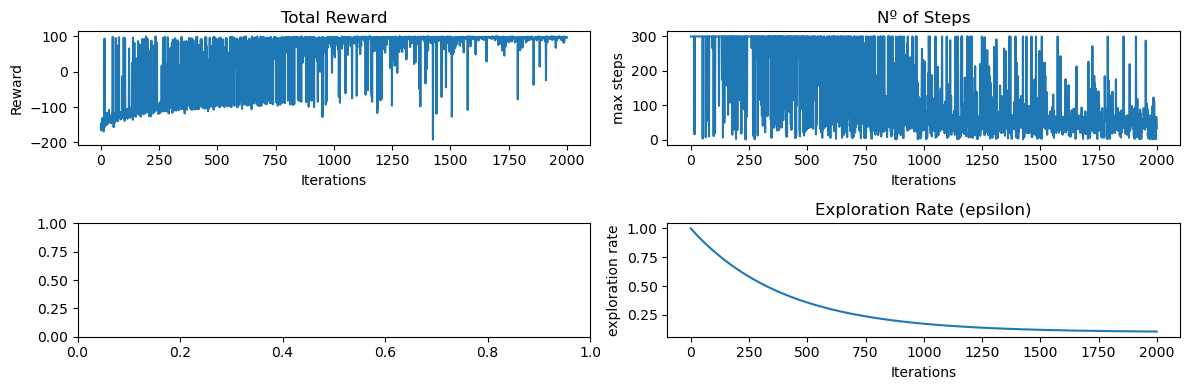

: 

In [ ]:
def plot_history(history: dict[str, np.ndarray]):
    if 'obedience' in history.keys() or 'exploration-rate' in history.keys(): nrow = 2
    else: nrow = 1
    _, ax = plt.subplots(nrow, 2, figsize = (12, 4))
    ax = ax.flatten()

    ax[0].plot(history['max-reward'])
    ax[0].set_title("Total Reward")
    ax[0].set_xlabel("Iterations")
    ax[0].set_ylabel("Reward")

    ax[1].plot(history['max-steps'])
    ax[1].set_title("Nº of Steps")
    ax[1].set_xlabel("Iterations")
    ax[1].set_ylabel("max steps")

    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    
    if 'obedience' in history.keys():
        ax[2].plot(history['obedience'])
        ax[2].set_title("Obedience Rate")
        ax[2].set_xlabel("Iterations")
        ax[2].set_ylabel("obedience rate")
        ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))

    if 'exploration-rate' in history.keys():
        ax[3].plot(history['exploration-rate'])
        ax[3].set_title("Exploration Rate (epsilon)")
        ax[3].set_xlabel("Iterations")
        ax[3].set_ylabel("exploration rate")
        ax[3].xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

plot_history(history)

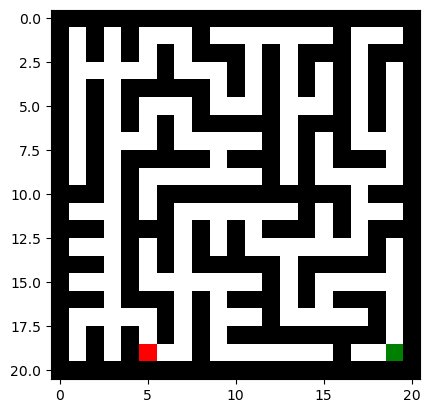

: 

In [ ]:
from matplotlib import animation

fig = plt.figure()
state = env.reset(False)
imgs = []

img = plt.imshow(env.render())
imgs.append([img])

step = 0
done = False
while not done and step < 150:
    action = argmax_random(Q[state])
    pre = env.env.get_current_position()
    state, _, done,_ ,_ = env.step(action, None)
    pos = env.env.get_current_position()
    img = plt.imshow(env.render(), animated = True)
    imgs.append([img])
    step += 1

ani = animation.ArtistAnimation(fig, imgs, interval = 150, blit = True, repeat_delay = 1000)
display(HTML(ani.to_jshtml()))

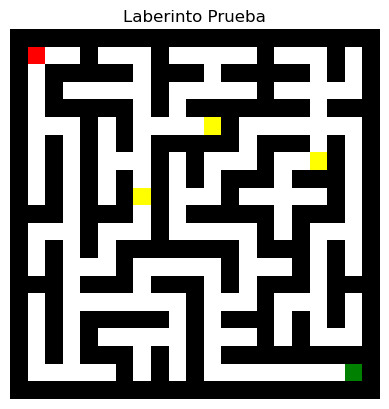

: 

In [ ]:
n_coins = 3
env2 = PositionStateWrapper(MazeEnv((10, 10), False, n_coins, True, 'rgb-array'))
_ = env2.reset(False) # build and place coins

W, H  = env2.env.maze_shape[0] - 1, env2.env.maze_shape[1] - 1
ssize = W * H
plt.imshow(env2.render())
plt.title("Laberinto Prueba"); 
plt.axis('off'); 


manager q table: (  8,   4     )
worker  q table: (  4, 400,   4)


Q Learning:   0%|          | 0/9000 [00:00<?, ?it/s]

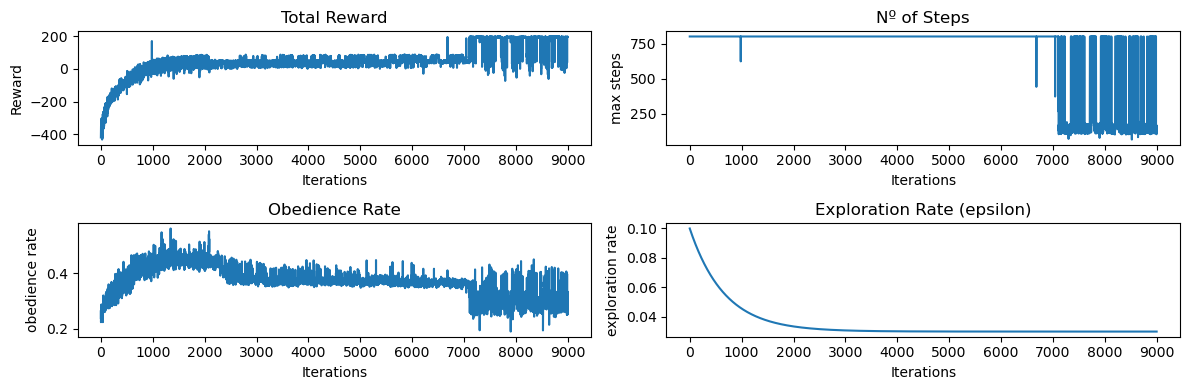

: 

In [22]:
# Q Tables
G    = [env2.env._end] + env2.env.get_coin_position()
Q1   = np.random.random((2 ** max(n_coins, 1), n_coins + 1)) # manager
Q2   = {
    order: np.zeros((ssize, 4))
    for order in range(n_coins + 1)
}

print(f"manager q table: ({Q1.shape[0]:>3d}, {Q1.shape[1]:>3d}     )")
print(f"worker  q table: ({len(Q2)    :>3d}, {Q2[0].shape[0]:>3d}, {Q2[0].shape[1]:>3d})")

# Parameters
gamma1  = 0.98
gamma2  = 0.95

amin, amax, arate = 0.03, 0.1, 0.0015
emin, emax, erate = 0.05, 1.0, 0.0025

max_step =  800
max_iter = 9000

obey_reward = 1
disobey_reward = -0.5

timeout_threshold =  150
timeout_penalty   = - 75

# History
history = {
    'max-steps': np.zeros(max_iter),
    'max-reward': np.zeros(max_iter),
    'exploration-rate': np.zeros(max_iter),
    'obedience': np.zeros(max_iter)
}

# Utils
def get_action(Q, state, epsilon) ->  int:
    q = Q[state]
    if random.random() > epsilon: 
        return argmax_random(q)
    else: 
        return random.randint(0, q.shape[0] - 1)

def state_id(state, w, h): 
    if len(state) == 2: return w * state[0] + state[1]
    return W * 2 * state[0] + 2 * state[1] + state[2]

def distance_goal(state, goal):
    state = (state[0] + 1, state[1] + 1)
    goal  = G[goal]
    distance = abs(state[0] - goal[0]) + abs(state[1] - goal[1])
    return distance

def disable_objective(env, coin: int, manager_state: list[int]) -> int:
    pos = env.env._available_coins.pop(coin)
    env.env._maze[pos[0], pos[1]] = 1
    manager_state[coin] = 0
    return manager_state

# Q Learning
for i in trange(0, max_iter, desc = "Q Learning: "):
    # Parameters Update
    epsilon = emin + (emax - emin) * np.exp(- erate * i)
    alpha   = amin + (amax - amin) * np.exp(- arate * i)

    # Reset Env
    random_ths   = 0.1 if i / max_iter < 0.7 else 0.01
    random_start = random.random() > random_ths
    state  = env2.reset(random_start)
    mstate = [0, ] if n_coins == 0 else [ 1 for _ in range(n_coins)]
    
    # random disable coin
    random_dis   = 0.01
    random_disable = random.random() < random_ths
    if n_coins > 0 and random_disable: 
        dis_coin = random.randint(0, n_coins - 1)
        mstate = disable_objective(env2, dis_coin, mstate)

    # Episode Track 
    steps  = 0
    obedience  = 0
    max_reward = 0

    done   = False
    prev_goal = None
    timeout_counter = 0
    min_distance    = np.inf
    while not done and steps < max_step:
        manager_state = sum([ mstate[i] * (2 ** i) for i in range(max(n_coins, 1))])
        manager_order = get_action(Q1, manager_state, epsilon) 
        if prev_goal is None: prev_goal = manager_order

        worker_state  = W * state[0] + state[1]
        worker_action = get_action(Q2[manager_order], worker_state, epsilon)
    
        new_state, reward, done, _, info = env2.step(worker_action, G[manager_order])
        if info['found_coin'] != -1: mstate[info['found_coin']] = 0

        new_manager_state = sum([ mstate[i] * (2 ** i) for i in range(max(n_coins, 1))])
        new_worker_state  = W  * new_state[0] + new_state[1]

        # manager reward
        prev_distance  = distance_goal(state, manager_order)
        new_distance   = distance_goal(new_state, manager_order)
        manager_reward = prev_distance - new_distance
        obedience      = obedience + (prev_distance < new_distance)

        if prev_goal == manager_order: 
            timeout_counter += 1 # int(min_distance > new_distance)
            min_distance    =  min(min_distance, new_distance)
        else: 
            min_distance    = np.inf
            timeout_counter = 0
            
        if timeout_counter >= timeout_threshold:
            manager_reward = timeout_penalty
            Q1[manager_state, manager_order] = (1 - alpha) * Q1[manager_state, manager_order] + \
                alpha * (manager_reward + gamma * np.max(Q1[new_manager_state]))
            break

        Q1[manager_state, manager_order] = (1 - alpha) * Q1[manager_state, manager_order] + \
            alpha * (manager_reward + gamma1 * np.max(Q1[new_manager_state]))

        # worker reward
        worker_reward  = reward
        Q2[manager_order][worker_state, worker_action] = (1 - alpha) * Q2[manager_order][worker_state, worker_action] + \
            alpha * (worker_reward  + gamma2 * np.max(Q2[manager_order][new_worker_state]))
        
        # update state
        state = new_state
        steps = steps + 1
        max_reward += reward

    history['max-steps'][i] = steps
    history['max-reward'][i] = max_reward
    history['obedience'][i]  = obedience / steps
    history['exploration-rate'][i] = alpha

plot_history(history)

In [23]:
keys = list(history.keys())

with open(f'history-q-feudal-coin-{n_coins}.csv', 'w') as f:
    f.write("index")
    for k in keys: 
        f.write("," + k)
    f.write("\n")
    for i in range(history[keys[0]].shape[0]):
        f.write(str(i))
        for k in keys:
            f.write("," + str(history[k][i]))
        f.write("\n")

: 

runned episode
animation created


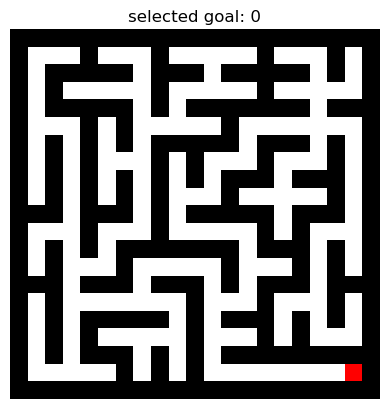

: 

In [27]:
import matplotlib.animation as animation

state = env2.reset(False)

steps  =  0
goals  = [1]
images = [env2.render()]
done   = False

mstate = [0, ] if n_coins == 0 else [ 1 for _ in range(n_coins)]
while not done and steps < 500:
    manager_state = sum([ mstate[i] * (2 ** i) for i in range(max(n_coins, 1))])
    manager_order = argmax_random(Q1[manager_state]) 

    worker_state  = W * state[0] + state[1]
    worker_action = argmax_random(Q2[manager_order][worker_state])

    new_state, reward, done, _, info = env2.step(worker_action, G[manager_order])
    if info['found_coin'] != -1: mstate[info['found_coin']] = 0

    goals.append(manager_order)
    images.append(env2.render())  
    state = new_state
    steps = steps + 1   


print("runned episode")

fig, ax = plt.subplots()
img = ax.imshow(images[0])
ax.axis("off")
title = ax.set_title("selected goal: ")
def animate(frame):
    img.set_array(images[frame])
    title.set_text(f"selected goal: {goals[frame]:1d}")
    return img, title

print("animation created")
ani = animation.FuncAnimation(fig, animate, frames=len(images), interval = 150, blit = True, repeat_delay = 1000)

writer = animation.PillowWriter(fps = 24, metadata=dict(artist='Rubén Cid, Aimar Nicuesa, Daniel Obreo'), bitrate=1800)
ani.save(f'q-rl-goal-coin-{n_coins}.gif', writer = writer)
display(HTML(ani.to_jshtml(default_mode = 'once')))

  0%|          | 0/1000 [00:00<?, ?it/s]

TypeError: distance_goal() takes 2 positional arguments but 3 were given

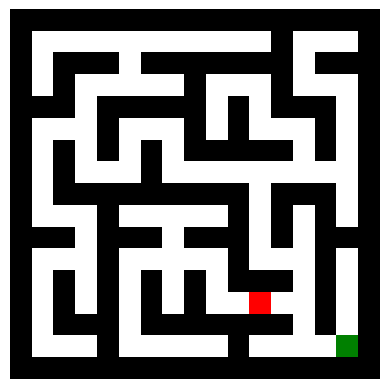

: 

In [ ]:
import random
from collections import defaultdict

n_coins = 0
env = PositionStateWrapper(MazeEnv((8, 8), False, n_coins, True, 'rgb-array'))

W, H = env.env.maze_shape
W, H = W - 1, H - 1
assert W % 4 == 0 and H % 4 == 0
ssize = W * H

_ = env.reset()
plt.imshow(env.render()); plt.axis('off')
plt.plot()

def state_id(state, w, h): 
    if len(state) == 2: return w * state[0] + state[1]
    return W * 2 * state[0] + 2 * state[1] + state[2]

res1 = 4
G    = [env.env._end] + env.env._coin_loc
Q1   = np.zeros((2 ** max(n_coins, 1), n_coins + 1)) # manager
Q2   = {
    order: np.zeros((ssize, 4))
    for order in range(n_coins + 1)
}

gamma   = 0.99

amin, amax, arate = 0.03, 0.1, 0.005
emin, emax, erate = 0.1 , 1.0, 0.005

max_step = 300
max_iter = 1000

obey_reward = 1
disobey_reward = -0.5
timeout_penalty = -1
timeout_threshold = 100

history = {
    'max-steps': np.zeros(max_iter),
    'max-reward': np.zeros(max_iter),
    'exploration-rate': np.zeros(max_iter),
    'obedience': np.zeros(max_iter)
}

def get_action(Q, state, epsilon) ->  int:
    q = Q[state]
    if random.random() < epsilon: 
        return argmax_random(q)
    else: 
        return random.randint(0, q.shape[0] - 1)
    
def softmax(q_values, temperature = 1): 
    q_exp = np.exp(q_values / temperature)
    return q_exp / np.sum(q_exp)

def get_action_soft(Q, state) -> int:
    probs = softmax(Q[state])
    return np.random.choice(len(probs), p = probs)
    
def set_worker_reward(reward, obeyed) -> float:
    return reward

def valid_order(state, order):
    if order == 4: return True
    else: 
        movement  = { # x, y
            0: np.array([ 1,  0]), # right 
            1: np.array([ 0,  1]), # bottom
            2: np.array([-1,  0]), # left
            3: np.array([ 0, -1])  # top
        } 
        
        movement = movement[order]
        new_state = (state[0] + 4 * movement[1], state[1] + 4 * movement[0])
        return 0 <= new_state[0] <= H and 0 <= new_state[1] <= W


def set_manager_reward(state, new_state, manager_order):
    manager_goal_reached = (new_state[0] // res1, new_state[1] // res1) == (state[0] // res1 + manager_order % res1, state[1] // res1 + manager_order // res1)
    if not valid_order(state, manager_order): return disobey_reward - 1
    return obey_reward if manager_goal_reached else disobey_reward

def distance_goal(state, goal):
    state = (state[0] + 1, state[1] + 1)
    goal  = G[goal]
    distance = abs(state[0] - goal[0]) + abs(state[1] - goal[1])
    return distance

for i in trange(0, max_iter):
    # epsilon = emin + (emax - emin) * np.exp(- erate * i)
    epsilon = max(emin, emax * (1 - i / (0.75 * max_iter)))
    # alpha   = amin + (amax - amin) * np.exp(- arate * i)
    alpha = max(amin, amax / (1 + arate * i))
    temperature = max(0.1, 2. * np.exp(- 0.005 * i))
    random_start = random.random() > 0.2

    steps = 0
    state = env.reset(random_start)
    state = state[0] - 1, state[1] - 1 # change origin
    mstate = [0, ] if n_coins == 0 else [1 for _ in range(n_coins)]

    done  = False

    distance    = np.inf
    obedience   = 0 
    max_reward  = 0
    path_length = 0
    timeout_counter = 0
    prev_order  = 0
    while not done and steps < max_step:

        # manager_state = (state[0] // res1, state[1] // res1, 0)
        # manager_state = W // res1 * 2 * manager_state[0] + 2 * manager_state[1] + manager_state[2]
        manager_state = sum([ mstate[i] * (2 ** i) for i in range(max(n_coins, 1))])
        manager_order = get_action(Q1, manager_state, epsilon)

        if prev_order != manager_order: timeout_counter = 0

        worker_state  = W  * state[0] + state[1]
        worker_state  = state_id(state, W, H)
        worker_action = get_action(Q2[manager_order], worker_state, epsilon)

        new_state, reward, done, _, info = env.step(worker_action, None)

        if info['found_coin'] != -1: mstate[info['found_coin']] = 0

        new_manager_state = sum([ mstate[i] * (2 ** i) for i in range(max(n_coins, 1))]) 
        new_worker_state  = W  * new_state[0] + new_state[1]

        # implement the feudal q learning for the Q1 and Q2
        #manager_reward = obey_reward if manager_order == (worker_action // 5) else disobey_reward

        prev_distance = distance_goal(env, state, manager_order)
        new_distance  = distance_goal(env, new_state, manager_order)
        obeyed        = prev_distance > new_distance

        #manager_visits[manager_state, manager_order] += 1
        if not obeyed: timeout_counter += 1
        # if timeout_counter > timeout_threshold: 
        #     Q1[manager_state, manager_order] -= alpha * timeout_penalty
        #     break

        # manager_reward = set_manager_reward(state, new_state, manager_order)
        adjusted_reward  = prev_distance - new_distance
        # adjusted_reward += exploration_bonus(manager_state, manager_order, manager_visits)
        Q1[manager_state, manager_order] = (1 - alpha) * Q1[manager_state, manager_order] + \
            alpha * (adjusted_reward + gamma * np.max(Q1[new_manager_state]))

        worker_reward = set_worker_reward(reward, obeyed)
        Q2[manager_order][worker_state, worker_action] = (1 - alpha) * Q2[manager_order][worker_state, worker_action] + \
            alpha * (worker_reward  + gamma * np.max(Q2[manager_order][new_worker_state]))

        state = new_state
        path_length += 1

        steps = steps + 1
        max_reward += reward
        obedience  += obeyed

    history['max-steps'][i] = steps
    history['max-reward'][i] = max_reward
    history['obedience'][i]  = obedience / steps
    history['exploration-rate'][i] = epsilon

plot_history(history)


In [ ]:
_, ax = plt.subplots(2, 2, figsize = (14, 14)); ax = ax.flatten()
ax[0].imshow(Q2[0][:, 0].reshape((H, W)))
ax[1].imshow(Q2[0][:, 1].reshape((H, W)))
ax[2].imshow(Q2[0][:, 2].reshape((H, W)))
ax[3].imshow(Q2[0][:, 3].reshape((H, W)))

: 

: 

In [ ]:
from matplotlib import animation

state = env.reset(False)
imgs = [env.render()]
orders = [4]

steps = 0
state = state[0] - 1, state[1] - 1 # change origin
mstate = (1, ) if n_coins == 0 else tuple([1] * n_coins)

done  = False

distance   = np.inf
obedience  = 0 
max_reward = 0
path_length = 0
timeout_counter = 0
prev_order  = 0
while not done and steps < max_step:

    # manager_state = (state[0] // res1, state[1] // res1, 0)
    # manager_state = W // res1 * 2 * manager_state[0] + 2 * manager_state[1] + manager_state[2]
    manager_state = sum([ mstate[i] * (2 ** i) for i in range(max(n_coins, 1))])
    manager_order = get_action(Q1, manager_state, epsilon)

    worker_state  = W  * state[0] + state[1]
    worker_state  = state_id(state, W, H)
    worker_action = get_action(Q2[manager_order], worker_state, epsilon)

    new_state, reward, done, _, info = env.step(worker_action, None)

    if info['found_coin'] != -1: mstate[info['found_coin']] = 0

    state = new_state
    steps = steps + 1
    imgs.append(env.render())
    orders.append(manager_order)

fig, ax = plt.subplots()
img = ax.imshow(imgs[0])
title = ax.set_title("Order: *")
def animate(frame):
    img.set_array(imgs[frame])
    title.set_text(f"Order {orders[frame]:1d}")
    return img, title

ani = animation.FuncAnimation(fig, animate, frames=len(imgs), interval = 150, blit = True, repeat_delay = 1000)
display(HTML(ani.to_jshtml()))

: 

: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Example data: A collection of color images (RGB) and their corresponding IDs
images = [np.random.rand(10, 10, 3) for _ in range(10)]  # Generate random RGB images
image_ids = [f"Image-{i}" for i in range(len(images))]

# Create the figure and axis
fig, ax = plt.subplots()
image_display = ax.imshow(images[0])  # Display the first color image
title = ax.set_title(f"ID: {image_ids[0]}")

# Update function for the animation
def update(frame):
    image_display.set_array(images[frame])  # Update the displayed image
    title.set_text(f"ID: {image_ids[frame]}")  # Update the title with the image ID
    return image_display, title

# Create the animation
ani = animation.FuncAnimation(
    fig, update, frames=len(images), interval=500, blit=True
)

display(HTML(ani.to_jshtml()))


: 

: 

In [ ]:
raise ValueError

: 

: 

In [ ]:
import random
from collections import defaultdict


class FeudalQTable(object):
    def __init__(self, action_space: int, epsilon: float=0.1, gamma: float=0.8, learning_rate: float = 0.01):
        self.action_space = action_space
        self.q_table = {
            0: defaultdict(lambda: np.full(action_space, 0.5)),
            1: defaultdict(lambda: np.full(action_space, 0.5)),
            2: defaultdict(lambda: np.full(action_space, 0.5)),
            3: defaultdict(lambda: np.full(action_space, 0.5)),
            4: defaultdict(lambda: np.full(action_space, 0.5)),
        }

        # Q learning parameters
        self.epsilon = epsilon
        self.gamma   = gamma
        self.learning_rate = learning_rate

        self.learning = True

    def __repr__(self):
        return f"FeudalQTable<action_space={self.action_space}>"

    def learning_mode(self, active: bool = True) -> None:
        self.learning = active

    def get_action(self, state: tuple[int, int, int]) -> int:
        (px, py, order) = state
        meta_mode = random.random() > self.epsilon
        if self.learning and not meta_mode: 
            return random.randint(0, self.action_space - 1)
        else:
            q_action = self.q_table[order][(px, py)]
            action   = argmax_random(q_action)
            return action

    def learn_table(self, 
                    state: tuple[int, int, int], 
                    action: int, reward: float, 
                    new_state: tuple[int, int, int], 
                    done: bool
    ) -> None:
        (px, py, order) = state
        (npx, npy, norder) = new_state

        q_old = self.q_table[order][(px, py)][action]
        q_max = np.max(self.q_table[norder][(npx, npy)])
        
        q_new = (1 - self.learning_rate) * q_old + self.learning_rate * (reward * self.gamma * q_max)
        self.q_table[order][(px, py)][action] = q_new

        


: 

: 

In [ ]:
import gymnasium

def estimate_obedience_rate(actions: list[int]) -> float:
    n_orders = len(actions) - 1
    if n_orders == 0: return 1
    obeyed_orders = sum(map(lambda o: o[0] == o[1], zip(actions[:-1], actions[1:])))
    return obeyed_orders / n_orders

class FeudalAgent(object):
    OBEY_REWARD: int = 0
    DISOBEY_REWARD: int = -1

    def __init__(self, action_space: int, num_levels: int = 3):
        assert num_levels >= 1, "At least one level in the hierarchy is required"
        self.action_space = action_space
        self.num_levels   = num_levels
        self.levels: dict[str, FeudalQTable] = {}
        
        if self.num_levels > 1: 
            for i in range(0, self.num_levels - 1):
                self.levels[i] = FeudalQTable(action_space + 1)
        
        self.levels[self.num_levels-1] = FeudalQTable(action_space)
        self.learning = True
        self.history  = None

    def learning_mode(self, active: bool = True) -> None:
        self.learning = active
        for m in self.levels.values():
            m.learning_mode(active)
        
    def adapt_state_level(self, state: tuple[int, int]) -> list[tuple[int, int]]:
        level_states = []
        for _ in range(self.num_levels):
            level_states.append(state)
            state = state[0] // 2, state[1] // 2
        
        level_states.reverse()
        return level_states
    
    def get_action(self, state: tuple[int, int]) -> list[int]:
        actions = [4] # dummy action
        level_states = self.adapt_state_level(state)
        for level in range(self.num_levels):
            level_table = self.levels[level]
            level_state = (*level_states[level], actions[-1]) 
            actions.append(level_table.get_action(level_state))

            state = f"({level_state[0]:>3d}-{level_state[1]:<3d}) order: {level_state[2]:<2d}"
            #print(f"level {level:>2d} -> action: {actions[-1]:>2d} state: {state}")

        return actions[1:] # remove dummy action

    def learn_tables(self, state: tuple[int, int], actions: list[int], reward: float, next_state: tuple[int, int], done: bool) -> None:
        level_states = self.adapt_state_level(state)
        next_level_states = self.adapt_state_level(next_state)
        actions = [4] + actions

        r = 0
        new_orders = [4]
        for i in range(self.num_levels):
            if i == 0: r = reward
            else: 
                if actions[i - 1] == 4: # random walk 
                    r = reward
                else:
                    if actions[i - 1] == actions[i]: # obey orders
                        r = reward # self.OBEY_REWARD 
                    else: 
                        r = self.DISOBEY_REWARD
                
            level_state = (*next_level_states[i], new_orders[-1]) 
            next_level_state = (*next_level_states[i], new_orders[-1]) 

            new_orders.append(self.levels[i].get_action(level_state))
            level_state = (*level_states[i], actions[i+1]) 

            self.levels[i].learn_table(level_state, actions[i + 1], r, next_level_state, done)

    def learn(self, env: gymnasium.Env | gymnasium.Wrapper, max_iter: int = 5000, max_steps: int = 2000) -> dict[str, np.ndarray]:
        self.learning_mode(True)

        if self.history is None:
            start_epoch  = 0
            self.history = {
                'max_steps' : np.zeros(max_iter),
                'max_reward': np.zeros(max_iter),
                'manager_accuracy': np.zeros(max_iter),
                'task_completion': np.zeros(max_iter),  # Success rate (task completion)
            }
        else:
            start_epoch  = self.history['max_steps'].shape[0]
            self.history = {
                'max_steps' : np.pad(self.history['max_steps'] , (0, max_iter), mode='constant', constant_values=0),
                'max_reward': np.pad(self.history['max_reward'], (0, max_iter), mode='constant', constant_values=0),
                'manager_accuracy': np.pad(self.history['manager_accuracy'], (0, max_iter), mode='constant', constant_values=0),
                'task_completion': np.pad(self.history['task_completion'], (0, max_iter), mode='constant', constant_values=0),
            }

        #if isinstance(env, gymnasium.Env): env.render_mode = None
        #else: env.env.render_mode = None

        for e in trange(0, max_iter, desc = 'training episode: '):

            state = env.reset(random.sample([True, False], k = 1, counts = [10, 90]))
            
            steps = 0
            done  = False

            total_reward = 0
            obedience    = []
            while not done and steps < max_steps:
                action = self.get_action(state)
                next_state, reward, done, _, _ = env.step(action[-1], None)
                self.learn_tables(state, action, reward, next_state, done)

                next_state = state

                steps        += 1
                total_reward += reward
                obedience.append(estimate_obedience_rate(action))

            # Track performance
            self.history['max_reward'][start_epoch + e] = total_reward
            self.history['max_steps'][start_epoch + e] = steps
            
            # Track Task Completion (if applicable)
            self.history['task_completion'][start_epoch + e] = 1 if done else 0

            # Manager's action accuracy (obedience rate)
            self.history['manager_accuracy'][start_epoch + e] = np.mean(obedience)

        return self.history                


: 

: 

In [ ]:
env = PositionStateWrapper(MazeEnv((8, 8), False, 0, True, 'rgb-array', False))

env.reset()
plt.imshow(env.render())
plt.axis('off')
plt.title("Maze")
plt.tight_layout()
plt.show()

: 

: 

In [ ]:
agent = FeudalAgent(4, 1)
agent.learning_mode(True)
history = agent.learn(env, max_iter=2000, max_steps=100)

: 

: 

In [ ]:
def smooth_moving_average(data: np.ndarray, window_size: int) -> np.ndarray:
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_training_history_with_moving_avg(history: dict, window_size: int = 10):
    """
    Plot various metrics with moving average smoothing applied.
    
    :param history: A dictionary containing the tracked data.
    :param window_size: Size of the moving window (for moving average).
    """
    episodes = np.arange(len(history['max_reward']))

    fig, axs = plt.subplots(2, 2, figsize=(15, 15))

    # Apply moving average smoothing
    smoothed_rewards = smooth_moving_average(history['max_reward'], window_size)
    smoothed_steps = smooth_moving_average(history['max_steps'], window_size)
    smoothed_manager_accuracy = smooth_moving_average(history['manager_accuracy'], window_size)
    smoothed_task_completion = smooth_moving_average(history['task_completion'], window_size)
    
    # Plot Total Reward
    axs[0, 0].plot(episodes[:len(smoothed_rewards)], smoothed_rewards, label='Smoothed Total Reward', color='blue')
    axs[0, 0].set_title(f'Smoothed Total Reward per Episode (Window: {window_size})')
    axs[0, 0].set_xlabel('Episode')
    axs[0, 0].set_ylabel('Total Reward')
    axs[0, 0].legend()

    # Plot Steps per Episode
    axs[0, 1].plot(episodes[:len(smoothed_steps)], smoothed_steps, label='Smoothed Steps', color='orange')
    axs[0, 1].set_title(f'Smoothed Steps per Episode (Window: {window_size})')
    axs[0, 1].set_xlabel('Episode')
    axs[0, 1].set_ylabel('Steps')
    axs[0, 1].legend()

    # Plot Manager Action Accuracy
    axs[1, 0].plot(episodes[:len(smoothed_manager_accuracy)], smoothed_manager_accuracy, label='Smoothed Manager Accuracy', color='green')
    axs[1, 0].set_title(f'Smoothed Manager Action Accuracy (Window: {window_size})')
    axs[1, 0].set_xlabel('Episode')
    axs[1, 0].set_ylabel('Accuracy')
    axs[1, 0].legend()

    # Plot Task Completion
    axs[1, 1].plot(episodes[:len(smoothed_task_completion)], smoothed_task_completion, label='Smoothed Task Completion', color='red')
    axs[1, 1].set_title(f'Smoothed Task Completion per Episode (Window: {window_size})')
    axs[1, 1].set_xlabel('Episode')
    axs[1, 1].set_ylabel('Completed (1 or 0)')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


plot_training_history_with_moving_avg(history, 5)

: 

: 

In [ ]:
def q_learning(env, s_space: int, a_space: int, n_epoch: int, gamma: float = 0.99, alpha: float = 0.003, max_steps: int = 1000):
    Q = np.ones((s_space, a_space))
    for e in tqdm(range(n_epoch)):
        # initial state
        env.reset()

        state = np.random.randint(s_space)
        env.s = state
        for _ in range(max_steps):

            # select action (random)
            if np.random.random() > 0.2: 
                action = np.argmax(Q[state])
            else: 
                action = np.random.randint(0, a_space)
            action = np.random.randint(0, a_space)
            
            # execute and get new state
            new_state, reward, done, _, _ = env.step(action)
            
            # update Q
            max_a = np.max(Q[new_state])
            Q[state, action] = (1 - alpha) * Q[state, action] + alpha * (reward + gamma * max_a)
            state = new_state

    return Q

env2 = CellStateWrapper(MazeEnv((8, 8), False, 0, True, 'rgb-array', False))
Q    = q_learning(env2, env2.env.maze_shape[0] * env2.env.maze_shape[1], 4, 1000)

def get_best_action(Q: np.ndarray, state: int) -> int:
    state_action = Q[state]
    return np.random.choice(np.where(state_action == state_action.max())[0])

: 

: 

In [ ]:
import matplotlib.animation as animation
imgs = []
fig, ax = plt.subplots()
ax.set_axis_off()

agent.learning_mode(False)

steps = 1
done  = False

state = env.reset(False)
img = env.render()

im  = ax.imshow(img)
imgs.append([im])
print(f"STEPS: {steps:05d} Action: {['*']}")

while not done and steps < 90:
    action = get_best_action(Q, state)
    next_state, reward, done, _, _ = env2.step(action, None)
    print(f"STEPS: {steps:05d} Action: {action} State: {state}")
    state  = next_state
    
    img = env.render()
    im  = ax.imshow(img, animated = True)
    imgs.append([im])

    steps += 1


ani = animation.ArtistAnimation(fig, imgs, interval=300, blit=True, repeat_delay=1000)
HTML(ani.to_jshtml())

: 

: 